# Assignment 4: Image Captioning

This assignment is somewhat short.  We want you to spend your time on the project instead!

This assignment explores models connecting different modalities - exploring a connection between images and text.  By the time you're done with this assignment, you'll have:

* explored MS COCO captioning dataset
* investigated a few captioning techniques
* worked with CLIP embeddings for images and captions

### Setup

* run ```sudo apt install unzip``` to install the unzip executable that is required for this assignment.

### Data

* Download the 2014 validation images, as well as their annotations from https://cocodataset.org/#download.  On your GCP instance, a command like ```curl http://images.cocodataset.org/zips/val2014.zip --output val2014.zip``` for each will do what you need. You'll also want the file named `annotations_trainval2014.zip` from the annotations directory on the cocodataset site.
* Unzip both files and name the corresponding directories `val2014` and `annotations` in this assignment directory (if they don't unzip into directories with those names).

**Note:** the file you are downloading is 6GB and takes a couple of minutes to unload.  Once you unzip the files, the ```val2014``` directory contains over 40,000 files.  Please **do not list all of the files in your notebook** because jupyter will be very unhappy with a cell with over 40,000 lines of output.

### Explore the dataset
Look in the ```annotations``` directory.  Which file(s) contain the image captions?  Load those into memory here.  Your end goal is to generate a list of tuples for each of train2014 (you don't need the actual images to do this!) and val2014 i.e. ```[(391895, 'val2014/COCO_val2014_000000391895.jpg', 'A man with a red helmet on a small moped on a dirt road. '), ...]```

In [18]:
### YOUR CODE HERE

import json

with open('annotations/captions_val2014.json') as val_cap:
    val2014_cap = json.load(val_cap)
    
with open('annotations/captions_train2014.json') as train_cap:
    train2014_cap = json.load(train_cap) 

# Validation Set
#val_id = {image['id']: "/".join(image['coco_url'].split("/")[-2:]) for image in val2014_cap['images']}
#val_id_ann = {image['id']: image['caption'] for image in val2014_cap['annotations']}
#val2014 = [(key, value, val_id_ann[key]) for key, value in val_id.items() if key in val_id_ann]


#Train Set
#train_id = {image['id']: "/".join(image['coco_url'].split("/")[-2:]) for image in train2014_cap['images']}
#train_id_ann = {image['id']: image['caption'] for image in train2014_cap['annotations']}
#train2014 = [(key, value, train_id_ann[key]) for key, value in train_id.items() if key in train_id_ann]

# Validation Set
val_id = {image['id']: "/".join(image['coco_url'].split("/")[-2:]) for image in val2014_cap['images']}
val_id_ann = {}
for image in val2014_cap['annotations']:
    image_id = image['image_id']
    caption = image['caption']
    if image_id in val_id_ann:
        val_id_ann[image_id].append(caption)
    else:
        val_id_ann[image_id] = [caption]

val2014 = [(key, value, caption) for key, value in val_id.items() for caption in val_id_ann.get(key, [])]


# Train Set
train_id = {image['id']: "/".join(image['coco_url'].split("/")[-2:]) for image in train2014_cap['images']}
train_id_ann = {}
for image in train2014_cap['annotations']:
    image_id = image['image_id']
    caption = image['caption']
    if image_id in train_id_ann:
        train_id_ann[image_id].append(caption)
    else:
        train_id_ann[image_id] = [caption]

train2014 = [(key, value, caption) for key, value in train_id.items() for caption in train_id_ann.get(key, [])]


### END YOUR CODE

In [12]:
train2014[:5]

[(57870,
  'train2014/COCO_train2014_000000057870.jpg',
  'A group of bike riders waiting to load bikes on a truck'),
 (398494,
  'train2014/COCO_train2014_000000398494.jpg',
  'A very young animal is being hand-fed from a bottle. '),
 (504616,
  'train2014/COCO_train2014_000000504616.jpg',
  'A group of chefs preparing food in a kitchen.'),
 (161919,
  'train2014/COCO_train2014_000000161919.jpg',
  'a cat on a laptop on a bed'),
 (457732,
  'train2014/COCO_train2014_000000457732.jpg',
  'Three young guys are having fun over the bed. ')]

In [16]:
val2014[5]

(522418,
 'val2014/COCO_val2014_000000522418.jpg',
 'A woman wearing a net on her head cutting a cake. ')

In [19]:
train_images_479495 = [record for record in train2014 if record[0] == 479495]
if train_images_479495:
    for image in train_images_479495:
        print(image)
else:
    print("Records with image ID 479495 not found in train2014.")

#Captions are different than the assertion. Does it have duplicate ids? 
#(479495, 'train2014/COCO_train2014_000000479495.jpg', 'A bike and a bench on the side of a street.')

(479495, 'train2014/COCO_train2014_000000479495.jpg', 'A bicycle is parked by a bench at night.')
(479495, 'train2014/COCO_train2014_000000479495.jpg', 'A bike on the platform of a public transportation stop at night.')
(479495, 'train2014/COCO_train2014_000000479495.jpg', 'A bicycle leans on a bench at a subway stop.')
(479495, 'train2014/COCO_train2014_000000479495.jpg', 'A bicycle parked next to a bench in a train station.')
(479495, 'train2014/COCO_train2014_000000479495.jpg', 'A bike and a bench on the side of a street.')


In [20]:
train_images_479495 = [record for record in train2014 if record[0] == 479495]
train_images_479495

[(479495,
  'train2014/COCO_train2014_000000479495.jpg',
  'A bicycle is parked by a bench at night.'),
 (479495,
  'train2014/COCO_train2014_000000479495.jpg',
  'A bike on the platform of a public transportation stop at night.'),
 (479495,
  'train2014/COCO_train2014_000000479495.jpg',
  'A bicycle leans on a bench at a subway stop.'),
 (479495,
  'train2014/COCO_train2014_000000479495.jpg',
  'A bicycle parked next to a bench in a train station.'),
 (479495,
  'train2014/COCO_train2014_000000479495.jpg',
  'A bike and a bench on the side of a street.')]

In [17]:
val_image_203564 = [record for record in val2014 if record[0] == 203564]
if val_image_203564:
    for image in val_image_203564:
        print(image)
else:
    print("Record with image ID 203564 not found in val2014.")

#Captions are different than the assertion. Does it have duplicate ids?
#(203564, 'val2014/COCO_val2014_000000203564.jpg', 'A clock with the appearance of the wheel of a bicycle ')

(203564, 'val2014/COCO_val2014_000000203564.jpg', 'A bicycle replica with a clock as the front wheel.')
(203564, 'val2014/COCO_val2014_000000203564.jpg', 'The bike has a clock as a tire.')
(203564, 'val2014/COCO_val2014_000000203564.jpg', 'A black metal bicycle with a clock inside the front wheel.')
(203564, 'val2014/COCO_val2014_000000203564.jpg', 'A bicycle figurine in which the front wheel is replaced with a clock\n')
(203564, 'val2014/COCO_val2014_000000203564.jpg', 'A clock with the appearance of the wheel of a bicycle ')


In [21]:
# Check for duplicate records with the same image ID
def find_duplicates(records):
    id_counts = {}
    duplicates = []

    for record in records:
        image_id = record[0]
        if image_id in id_counts:
            id_counts[image_id] += 1
            if id_counts[image_id] == 2:
                duplicates.append(image_id)
        else:
            id_counts[image_id] = 1

    return duplicates

val_duplicates = find_duplicates(val2014)
train_duplicates = find_duplicates(train2014)

print("Validation Set - Number of duplicate records with the same image ID:", len(val_duplicates))
print("Train Set - Number of duplicate records with the same image ID:", len(train_duplicates))


#only one id and annotation are saved into the list. 

Validation Set - Number of duplicate records with the same image ID: 40504
Train Set - Number of duplicate records with the same image ID: 82783


In [42]:
image_id_479495 = 479495

# Check for duplicates with the specified image ID
duplicates = [annotation for annotation in train2014_cap['annotations'] if annotation['image_id'] == image_id_479495]

# Print the duplicates
print("Number of duplicates with image ID", image_id_479495, ":", len(duplicates))
print("Duplicate annotations:")
for duplicate in duplicates:
    print(duplicate)

Number of duplicates with image ID 479495 : 5
Duplicate annotations:
{'image_id': 479495, 'id': 764, 'caption': 'A bicycle is parked by a bench at night.'}
{'image_id': 479495, 'id': 5315, 'caption': 'A bike on the platform of a public transportation stop at night.'}
{'image_id': 479495, 'id': 11039, 'caption': 'A bicycle leans on a bench at a subway stop.'}
{'image_id': 479495, 'id': 13982, 'caption': 'A bicycle parked next to a bench in a train station.'}
{'image_id': 479495, 'id': 14468, 'caption': 'A bike and a bench on the side of a street.'}


In [43]:
image_id_203564 = 203564

# Check for duplicates with the specified image ID
duplicates = [annotation for annotation in val2014_cap['annotations'] if annotation['image_id'] == image_id_203564]

# Print the duplicates
print("Number of duplicates with image ID", image_id_203564, ":", len(duplicates))
print("Duplicate annotations:")
for duplicate in duplicates:
    print(duplicate)

Number of duplicates with image ID 203564 : 5
Duplicate annotations:
{'image_id': 203564, 'id': 37, 'caption': 'A bicycle replica with a clock as the front wheel.'}
{'image_id': 203564, 'id': 181, 'caption': 'The bike has a clock as a tire.'}
{'image_id': 203564, 'id': 478, 'caption': 'A black metal bicycle with a clock inside the front wheel.'}
{'image_id': 203564, 'id': 6637, 'caption': 'A bicycle figurine in which the front wheel is replaced with a clock\n'}
{'image_id': 203564, 'id': 6802, 'caption': 'A clock with the appearance of the wheel of a bicycle '}


In [22]:
#Not sure why assertion fails. does not provide an error message. 
#Duplicate image ids with 5 annotation options for each of these examples  
assert (479495,'train2014/COCO_train2014_000000479495.jpg','A bicycle is parked by a bench at night.') in train2014
assert (203564,'val2014/COCO_val2014_000000203564.jpg','A black metal bicycle with a clock inside the front wheel.') in val2014

In [18]:
# Cell if you want to write code to answer the questions below.

### YOUR CODE HERE
print(f'Q1. Total number of images with captions in the training set: {len(train2014)}')

#Question 2
import numpy as np
total_images = np.round(len(train2014_cap['annotations'])/len(train2014_cap['images']))
print('Q2. Total number of captions per image (rounded to nearest integer) in the training set:', total_images)
       
#Question 3 
# Collect all the training captions
train_captions = [caption['caption'] for caption in train2014_cap['annotations']]
# Split captions into individual words
words = [word for caption in train_captions for word in caption.split()]
       
print(f'Q3. Total number of unique words are in the vocabulary in the training set: {len(set(words))}')

### END YOUR CODE    

Q1. Total number of images with captions in the training set: 82783
Q2. Total number of captions per image (rounded to nearest integer) in the training set: 5.0
Q3. Total number of unique words are in the vocabulary in the training set: 44535


### Questions (Part A)

1. How many images do we have captions for in the training set?
2. How many captions do we have per image (rounded to nearest integer) in the training set?
3. If you just split the training captions on whitespace and do nothing else, how many unique words are in the vocabulary?

Given your answer to 3, think about what you might need to do with that few examples and that large of a vocabulary?  (Use pretrained embeddings from a massive semi-supervised dataset, keeping only the top-k tokens, smarter tokenization, ...).  You don't need to write your answer anywhere, but given how often these problems arise in NLP, you should be feeling more confident at this point in the course how to handle these situations!

## Let's look at some of the examples!

2023-07-16 13:35:01.426704: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


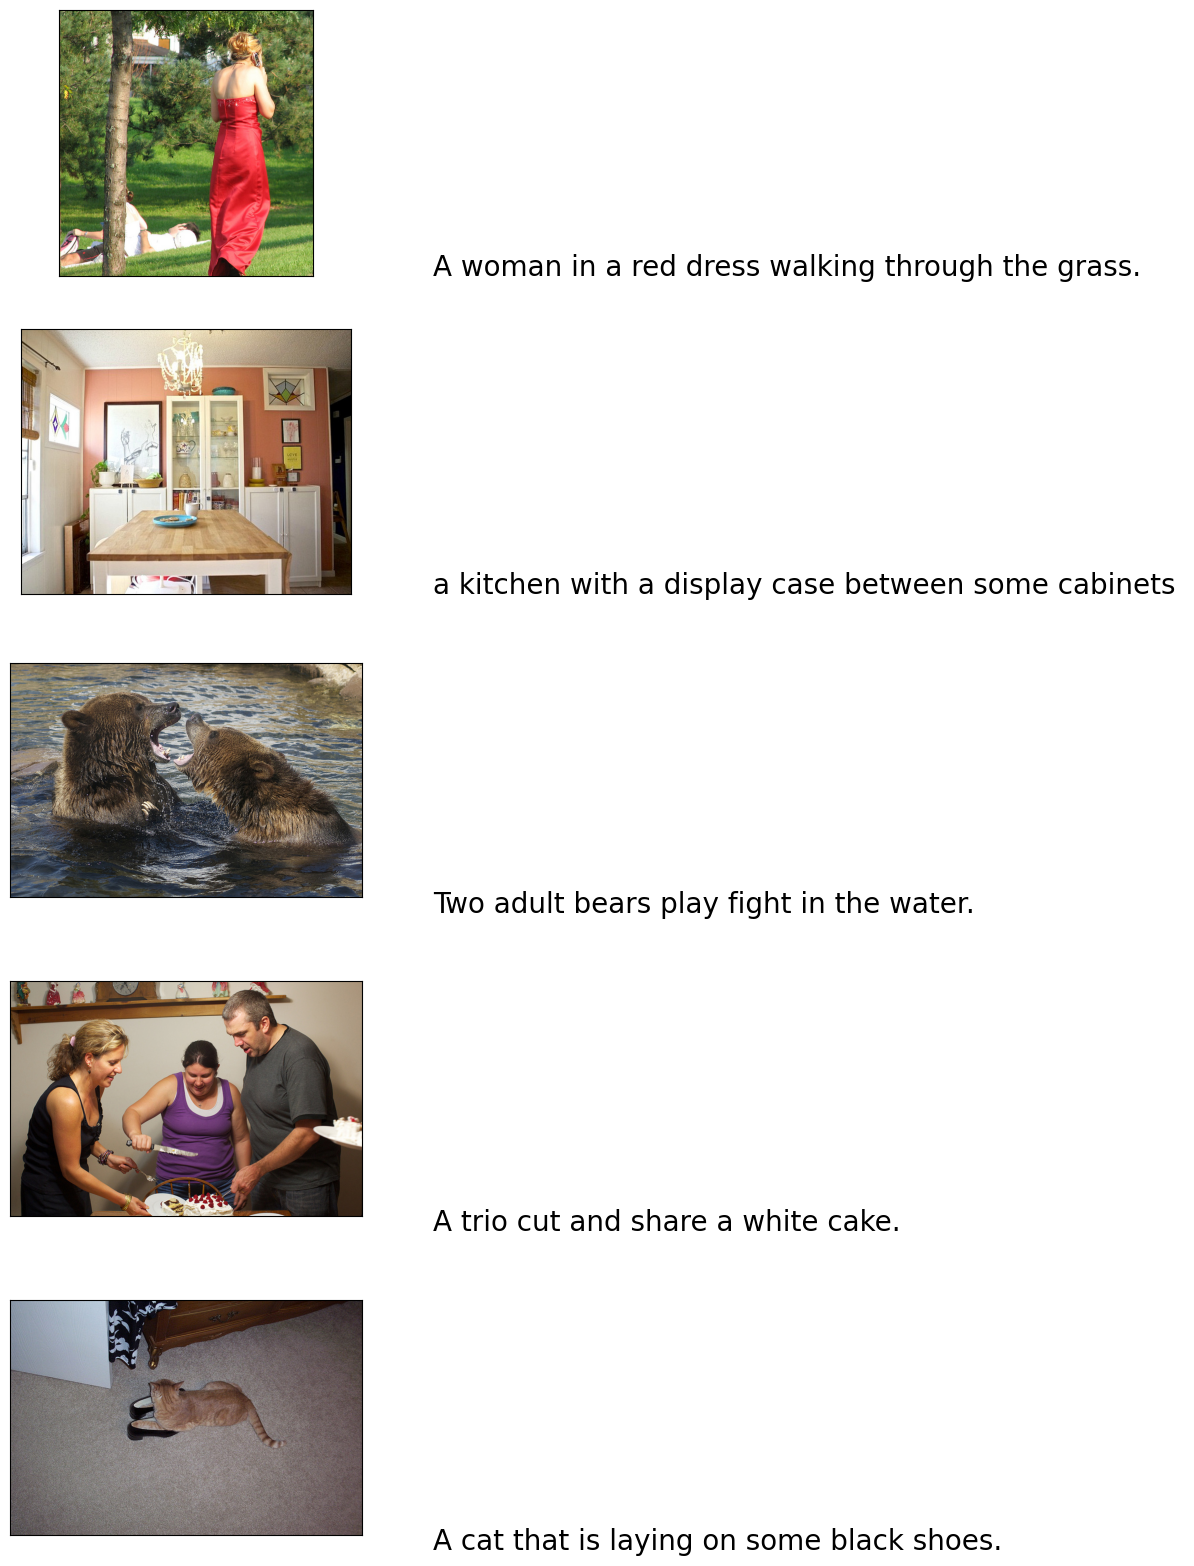

In [19]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array
import random

samples = 5
n = 1
fig = plt.figure(figsize=(10,20))
for i in range(samples):
    image_caption = val2014[random.randint(0, len(val2014))]
    image_load = load_img(image_caption[1])
    
    ax = fig.add_subplot(samples,2,n,xticks=[],yticks=[])
    ax.imshow(image_load)
    n += 1
    
    ax = fig.add_subplot(samples,2,n)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.text(0, 0, image_caption[2], fontsize=20)
    n += 1
plt.show()

# Foundational image captioning papers

## Show & Tell

[Show and Tell: A Neural Image Caption Generator](https://arxiv.org/pdf/1411.4555.pdf) was the first step towards neural image captioning.  Fundamentally it is an encoder-decoder scheme similar to what we've seen in class.  Concretely, it uses the CNN structure of an (at the time) state of the art image classification CNN as the encoder and it uses an LSTM as a decoder.  As in the generation models in class, it continues to generate text until a special "stop" token is emitted.  After **reading** the paper, answer the following questions:

### Questions (Part B)

1.  What parts of the CNN were fine-tuned during the image caption generation training process?
2.  What was the biggest concern when deciding how to train the model?
3.  How was the encoded image representation input into the decoder?
4.  Given we are "translating" from an image to a caption (without a length constraint), which evaluation metric did the authors determine was reasonable for a top line metric?
5.  What beam width is equivalent to one where you select the highest probability word in each decoding step?


## Deep Visual Alignment

[Deep Visual-Semantic Alignments for Generating Image Descriptions](https://cs.stanford.edu/people/karpathy/cvpr2015.pdf) is a fun read for which we will ask no questions.  Its critical insights are around understanding an image as a composition of regions, and building upon that understanding to construct both a caption for the whole image, but labels for its consistuent parts.

## Show, Attend & Tell

[Show, Attend & Tell](https://arxiv.org/pdf/1502.03044.pdf) applies the same "provide the decoder more context, as directly as possible" trick we've seen over the course: adding attention.  After **skimming** the paper, answer the following questions:

### Questions (Part C)

1. What is the model paying attention to?
2. What do the figures with highlight shading represent in Figures 2, 3 and 5?

# Exploring a MS COCO captioner

There are many examples of image captioners ML engineers have built on the MS COCO dataset you explored. [This one](https://replicate.com/rmokady/clip_prefix_caption) uses a (more) modern large language model as its decoder, GPT-2.  

* **Explore** the samples and play with using beam search and not.  What do you notice?

This is an example from the Show & Tell paper of a low-quality caption (see figure 5).  The GPT-2 model proposes "the car that person drove to the hospital." vs. "A yellow school bus parked in a parking lot" from the original paper. ![Misclassified](littlecar.png) 

# CLIP Embeddings and Image Classification

The [CLIP paper](https://arxiv.org/pdf/2103.00020.pdf)  describes a system that emits encodings that represent both images and text captions. The system learns to match a picture with its caption so the encoding for the image and the encoding for an associated caption should have a very high cosine similarity.  Systems like DALL-E use CLIP embeddings to generate images based on a text description by using the text encoding to get the image encoding and then processing the image encoding to generate the final image.  We're going to use CLIP in the opposite direction.  Namely we're going to use CLIP embeddings to classify images, that is to score a set of captions for an image based on the image's content.


Unfortunelty there is a bug in HuggingFace that affects its interaction with Keras and the model we want to use.  Therefore we need to roll back the version of tensorflow to make it work.

In [20]:
!pip install -q -U tensorflow==2.10

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-cpu 2.11.0 requires keras<2.12,>=2.11.0, but you have keras 2.10.0 which is incompatible.
tensorflow-cpu 2.11.0 requires tensorboard<2.12,>=2.11, but you have tensorboard 2.10.1 which is incompatible.
tensorflow-cpu 2.11.0 requires tensorflow-estimator<2.12,>=2.11.0, but you have tensorflow-estimator 2.10.0 which is incompatible.

[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: pip install --upgrade pip


We can use the HuggingFace implementation of CLIP to experiment with this multimodal capability. 

In [21]:
!pip install -q transformers


[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: pip install --upgrade pip


In [22]:
import tensorflow as tf
from PIL import Image
import requests
from transformers import CLIPProcessor, TFCLIPModel

In [23]:
model = TFCLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

Downloading:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/606M [00:00<?, ?B/s]

2023-07-16 13:38:01.589934: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-16 13:38:11.347777: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 101187584 exceeds 10% of free system memory.
2023-07-16 13:38:12.098260: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 101187584 exceeds 10% of free system memory.
2023-07-16 13:38:12.228518: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 101187584 exceeds 10% of free system memory.
2023-07-16 13:38:16.399074: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 101187584 exceeds 10% of free system memory.
2023-07-16 13:38:16.534038: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 101

Downloading:   0%|          | 0.00/316 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/568 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/862k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Now let's begin our experiment.  We're going select two images that contain both zebras and cars.  They may contain other things as well.  We're also going to generate a set of captions that we will score.  Specifically, we'll pass the output for the captions through a softmax to give us a probability distribution over the four captions.

In [24]:
# Example tags: animal = zebra, transport = car

urls = ["https://farm1.staticflickr.com/9/15631288_605abb3096_z.jpg", #zebras foreground, cars background
        "https://farm4.staticflickr.com/3057/3033996041_11293469b7_z.jpg"]  #zebra foreground, tiny car background
captions = ["a photo of cars",
            "a photo of a giraffe",
            "a photo of zebras in a field",
            "a photo of some zebras and cars"]

for url in urls:
    image = Image.open(requests.get(url, stream=True).raw)

    inputs = processor(
        text=captions, images=image, return_tensors="tf", padding=True
    )

    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
    probs = tf.nn.softmax(logits_per_image, axis=1)  # we can take the softmax to get the label probabilities
    
    print()
    print(url)
    for i, caption in enumerate(captions):
        print('%40s - %.4f' % (caption, probs[0, i]))


https://farm1.staticflickr.com/9/15631288_605abb3096_z.jpg
                         a photo of cars - 0.0020
                    a photo of a giraffe - 0.0864
            a photo of zebras in a field - 0.0219
         a photo of some zebras and cars - 0.8898

https://farm4.staticflickr.com/3057/3033996041_11293469b7_z.jpg
                         a photo of cars - 0.0000
                    a photo of a giraffe - 0.0000
            a photo of zebras in a field - 0.9740
         a photo of some zebras and cars - 0.0259


The CLIP embeddings allow us to associate captions with images.  Specifically, we can build a classifier that assigns probabilities to each of the captions.  We want the highest probability to go to the most descriptive caption out of the four captions for the given image.  Notice here that even though both images contain zebras, one of them features a line of clearly visible cars.  The other image only has one small car off in the distance.  Note that the first image with the cars scores high for the caption of ```a photo of some zebras and cars``` because the zebras and cars are very visible.  The second image scores highest for ```a photo of zebras in a field``` but the small car is less noticed but scores above a zero.

In [25]:
# Example tags: two dogs in bike, human bike tiny dog

urls = ["http://farm1.staticflickr.com/8/10896131_6a184b48cb_z.jpg",  #2 dogs in bike basket
        "http://farm4.staticflickr.com/3082/2797293301_dd26fd613f_z.jpg"] #human and bike with tiny dog
captions = ["a photo of a dog",
            "a photo of some dogs in a basket",
            "a photo of a bike",
            "a photo of some dogs with a bike"]

for url in urls:
    image = Image.open(requests.get(url, stream=True).raw)

    inputs = processor(
        text=captions, images=image, return_tensors="tf", padding=True
    )

    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
    probs = tf.nn.softmax(logits_per_image, axis=1)  # we can take the softmax to get the label probabilities
    
    print()
    print(url)
    for i, caption in enumerate(captions):
        print('%40s - %.4f' % (caption, probs[0, i]))


http://farm1.staticflickr.com/8/10896131_6a184b48cb_z.jpg
                        a photo of a dog - 0.0002
        a photo of some dogs in a basket - 0.0454
                       a photo of a bike - 0.0008
        a photo of some dogs with a bike - 0.9536

http://farm4.staticflickr.com/3082/2797293301_dd26fd613f_z.jpg
                        a photo of a dog - 0.0007
        a photo of some dogs in a basket - 0.0001
                       a photo of a bike - 0.9527
        a photo of some dogs with a bike - 0.0465


Again, these two images both contain bicycles and dogs.  The first image is two dogs in a basket on the front of a bike.  While the bike is visible, the two dogs are the focus of the image.  The second image features a person with their bike.  The bike happens to contain a small dog.  We would expect the embeddings to reflect the different emphases of the photos and indeed they do.

In [26]:
# Example tags: animal = dog, transport = bike

urls = ["http://farm1.staticflickr.com/124/405495389_d4316b1224_z.jpg",   #dog foreground and tiny bikes background
        "http://farm8.staticflickr.com/7194/6991675037_3c298541c0_z.jpg"] #motorbike foreground, many bikes and tiny dog background
captions = ["a photo of a dog",
            "a photo of a motorbike",
            "a photo of a plane",
            "a photo of some bikes"]

for url in urls:
    image = Image.open(requests.get(url, stream=True).raw)

    inputs = processor(
        text=captions, images=image, return_tensors="tf", padding=True
    )

    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
    probs = tf.nn.softmax(logits_per_image, axis=1)  # we can take the softmax to get the label probabilities
    
    print()
    print(url)
    for i, caption in enumerate(captions):
        print('%40s - %.4f' % (caption, probs[0, i]))


http://farm1.staticflickr.com/124/405495389_d4316b1224_z.jpg
                        a photo of a dog - 0.9986
                  a photo of a motorbike - 0.0003
                      a photo of a plane - 0.0011
                   a photo of some bikes - 0.0000

http://farm8.staticflickr.com/7194/6991675037_3c298541c0_z.jpg
                        a photo of a dog - 0.0013
                  a photo of a motorbike - 0.8968
                      a photo of a plane - 0.0000
                   a photo of some bikes - 0.1018


For the third example, the first image includes a dog in the foreground and a number of small bikes in the distant background.  You can look at the annotations associated with the image to see where these objects are located. The second image includes a motorbike/motorcycle in the the foreground but a number of bikes and a tiny dog in the background.  Again we're hand crafting these captions to include the items in the image but we want the score for the caption to reflect what's in the foreground of the image.  

Now it is your turn.  You will essentially replicate the examples above but you will do it with images **you** select.  First you need to select *two* images for processing. Go to [the COCO Explorer](https://cocodataset.org/#explore), click on two tag icons: an animal (see icon column of animals) and a mode of transportation (see icon column of ), and search. (You pick which; you might have to try a few combinations until you get multiple image results.)

Find two different images that each contain your animal and your mode of transportation.  It's okay if they contain other things as well.  If you click on the URL icon above each image, you'll see a link to the annotated image and the original (unlabeled) image. Put the original image link in the code cell below *your image 1 url* and *your image 2 url*, then create four captions that mention only one of the objects each vs both objects together. You can see the captions we created for the three examples above.  The goal is to get probabilities above 0.85 for the caption that best describes the first image and the caption that best describes the second image.

As in the examples above, you must find a pair of images with the same two objects tagged in them, but which get different results for which caption has the highest probability according to the CLIP model.

Note which object tags you used, and give a brief explanation of what looks different about the two images that you think made them get different CLIP results for the most likely caption.  Enter that explanation in the cell below.  You **do not need to enter it in the answers sheet**.  Just leave it in the notebook that you submit. 

In [32]:
# Example tags: animal = elephant, transportation = train

urls = ["http://farm8.staticflickr.com/7252/7846835264_2c93071735_z.jpg", #Elephants in forground with a train in background
        "http://farm7.staticflickr.com/6079/6100661915_451209cbf2_z.jpg"] #A train at the station with ad with an elephant on it
captions = ["a photo of an elephant",
            "a photo of a train",
            "a photo of a bag",
            "a photo of some animals"]

for url in urls:
    image = Image.open(requests.get(url, stream=True).raw)

    inputs = processor(
        text=captions, images=image, return_tensors="tf", padding=True
    )

    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
    probs = tf.nn.softmax(logits_per_image, axis=1)  # we can take the softmax to get the label probabilities
    
    print()
    print(url)
    for i, caption in enumerate(captions):
        print('%40s - %.4f' % (caption, probs[0, i]))


http://farm8.staticflickr.com/7252/7846835264_2c93071735_z.jpg
                  a photo of an elephant - 0.9636
                      a photo of a train - 0.0003
                        a photo of a bag - 0.0000
                 a photo of some animals - 0.0361

http://farm7.staticflickr.com/6079/6100661915_451209cbf2_z.jpg
                  a photo of an elephant - 0.0002
                      a photo of a train - 0.9952
                        a photo of a bag - 0.0038
                 a photo of some animals - 0.0009


### Questions (Part D)

1. What is the animal tag you selected?

2. What is the transportation tag you selected?

3. What is the probability associated with the most likely caption for image 1?

4. What is the probability associated with the most likely caption for image 2?

**(Answer 5 below but do NOT enter your sentences in the answers file)**

5. Why do you think the differences between your two images are reflected in the 4 captions you produced.  

Please answer in two to four sentences right here: 

The first image does have a "train" on left side with the backside of 3 elephants. If you look closely at the image labeled as a train you will notice it looks more like an open air tram with a train front. This explains the winning caption for the first image. In the second image, an actual train in the station is displayed with a photo advert of the profile of an elephant in the field of few. 

## Yay, you're done with your 266 homework.  Now focus on your project!